# ECE 590, Fall 2019 
## Problem Set 4
* ### __Important :__  You are not allowed to use built-in optimizers from Pytorch or any other Python Deep Learning environment. 

## Full name: 


### Problem 1 (First-order Optimization Methods)

In [83]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np


# Download and prepare the MNIST data set 
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

"""
The data features can be extracted as train_dataset/test_dataset.data
The labels can be extracted as train_dataset/test_dataset.targets 
Note that the data are 28x28 images which you will have to transform to vectors.  
"""


'\nThe data features can be extracted as train_dataset/test_dataset.data\nThe labels can be extracted as train_dataset/test_dataset.targets \nNote that the data are 28x28 images which you will have to transform to vectors.  \n'

In [111]:
## SGD correction
class logistic_regression_sgd(nn.Module):
    def __init__(self, n_features, out_features, bias, alpha, lambdaf):
        super(logistic_regression_sgd, self).__init__()
        self.linear1 = nn.Linear(n_features, n_classes)
        self.alpha = alpha
        self.lambdaf = lambdaf

    def forward(self, x):
        a1 = self.linear1(x)
        return a1
    
    def update(self, grad):
        with torch.no_grad():
            self.linear1.weight -= self.alpha * grad

batch_size_list = [1,500,6*10**4]
lambdaf_list = [.1,1]
print("Stochastic Gradient Descent")
            
for batch_size in batch_size_list:

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)
    
    for lambdaf in lambdaf_list:
        alpha = .001
        n_features = 784
        n_classes = 10
        
        model = logistic_regression_sgd(n_features, n_classes, True, alpha, lambdaf = lambdaf)
        criterion = nn.CrossEntropyLoss()
        losses = []
        epoch = 5
        for i in range(epoch):
            for (x_train, y_train) in trainloader:
                x_train = Variable(x_train.view(-1, 28 * 28))
                y_train = Variable(y_train)
                y_hat_train = model(x_train) # Forward pass
                lf = torch.norm(model.linear1.weight, p = 'fro')
                loss = criterion(y_hat_train, y_train) + model.lambdaf * lf
                loss.backward()      # backward Pass
                model.update(model.linear1.weight.grad)
                losses.append(loss.item())

            with torch.no_grad():
                model.eval()
                test_loss = 0
                correct = 0
                for x_test, y_test in testloader:
                    x_test = Variable(x_test.view(-1, 28 * 28))
                    y_test = Variable(y_test)
                    y_hat_test = model(x_test)
                    test_loss += criterion(y_hat_test, y_test).item()
                    pred = y_hat_test.argmax(dim=1, keepdim=True)
                    correct += pred.eq(y_test.view_as(pred)).sum().item()

            test_loss = (test_loss*batch_size)/len(testloader.dataset)
            print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}%, Batch Size: {}, Lambda:{:.2f}'.format(
            i+1, test_loss, 100. * correct / len(testloader.dataset), batch_size, lambdaf))
        print("--------------------------------")

Stochastic Gradient Descent
Epoch: 1, Loss: 410.0344, Accuracy: 74.2000%, Batch Size: 1, Lambda:0.10
Epoch: 2, Loss: 980.5943, Accuracy: 72.4000%, Batch Size: 1, Lambda:0.10
Epoch: 3, Loss: 1297.1460, Accuracy: 71.8200%, Batch Size: 1, Lambda:0.10
Epoch: 4, Loss: 1321.8522, Accuracy: 72.4300%, Batch Size: 1, Lambda:0.10
Epoch: 5, Loss: 1792.0869, Accuracy: 71.4500%, Batch Size: 1, Lambda:0.10
--------------------------------
Epoch: 1, Loss: 435.6182, Accuracy: 41.8700%, Batch Size: 1, Lambda:1.00
Epoch: 2, Loss: 634.6593, Accuracy: 50.0300%, Batch Size: 1, Lambda:1.00
Epoch: 3, Loss: 1103.9699, Accuracy: 49.3900%, Batch Size: 1, Lambda:1.00
Epoch: 4, Loss: 1664.8859, Accuracy: 40.4800%, Batch Size: 1, Lambda:1.00
Epoch: 5, Loss: 2320.2347, Accuracy: 33.9900%, Batch Size: 1, Lambda:1.00
--------------------------------
Epoch: 1, Loss: 0.5395, Accuracy: 83.8600%, Batch Size: 500, Lambda:0.10
Epoch: 2, Loss: 0.4677, Accuracy: 87.2400%, Batch Size: 500, Lambda:0.10
Epoch: 3, Loss: 0.4959, 

In [99]:
# Nestrov Method 
class logistic_regression_nestrov(nn.Module):
    def __init__(self, n_features, out_features, bias, alpha, beta, lambdaf):
        super(logistic_regression_nestrov, self).__init__()
        self.linear1 = nn.Linear(n_features, n_classes)
        self.softmax = nn.Softmax()
        self.alpha = alpha
        self.lambdan = 0
        self.lambdaf = lambdaf
        self.t = torch.zeros(n_classes,n_features)

    def forward(self, x):
        y = self.linear1(x)
        #y = self.softmax(a1)
        return y

    def update(self, grad):
        with torch.no_grad():
            self.lambdan = (1+np.sqrt(1+4*self.lambdan**2))/2
            next_lambdan = (1+np.sqrt(1+4*self.lambdan**2))/2
            self.gamma = (1-self.lambdan)/next_lambdan
            next_t = self.linear1.weight - self.alpha * grad
            self.linear1.weight = torch.nn.Parameter((1 - self.gamma) * next_t + self.gamma * self.t)
            self.t = next_t
            
batch_size_list = [1,500,6*10**4]
lambdaf_list = [.1,1]
print("Nestrov Method")

for batch_size in batch_size_list:
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)
    for lambdaf in lambdaf_list:
        alpha = .001
        n_features = 784
        n_classes = 10
        beta = .95
      
        model = logistic_regression_nestrov(n_features, n_classes, True, alpha, beta, lambdaf)
        criterion = nn.CrossEntropyLoss()
        losses = []
        epoch = 5
        for i in range(epoch):
            for (x_train, y_train) in trainloader:
                x_train = Variable(x_train.view(-1, 28 * 28))
                y_train = Variable(y_train)
                y_hat_train = model(x_train) # Forward pass
                lf = torch.norm(model.linear1.weight, p = 'fro')
                loss = criterion(y_hat_train, y_train) + model.lambdaf * lf
                loss.backward()      # backward Pass
                model.update(model.linear1.weight.grad)
                losses.append(loss.item())

            with torch.no_grad():
                model.eval()
                test_loss = 0
                correct = 0
                for x_test, y_test in testloader:
                    x_test = Variable(x_test.view(-1, 28 * 28))
                    y_test = Variable(y_test)
                    y_hat_test = model(x_test)
                    test_loss += criterion(y_hat_test, y_test).item()
                    pred = y_hat_test.argmax(dim=1, keepdim=True)
                    correct += pred.eq(y_test.view_as(pred)).sum().item()

            test_loss = (test_loss*batch_size)/len(testloader.dataset)
            print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}%, Batch Size: {}, Lambda:{:.2f}'.format(
            i+1, test_loss, 100. * correct / len(testloader.dataset), batch_size, lambdaf))
        print("--------------------------------")

Nestrov Method
Epoch: 1, Loss: 97.9568, Accuracy: 72.9800%, Batch Size: 1, Lambda:0.10
Epoch: 2, Loss: 242.1293, Accuracy: 86.6200%, Batch Size: 1, Lambda:0.10
Epoch: 3, Loss: 408.0849, Accuracy: 83.6100%, Batch Size: 1, Lambda:0.10
Epoch: 4, Loss: 493.4856, Accuracy: 84.0400%, Batch Size: 1, Lambda:0.10
Epoch: 5, Loss: 540.1819, Accuracy: 81.8600%, Batch Size: 1, Lambda:0.10
--------------------------------
Epoch: 1, Loss: 117.1002, Accuracy: 54.6400%, Batch Size: 1, Lambda:1.00
Epoch: 2, Loss: 256.6457, Accuracy: 44.1200%, Batch Size: 1, Lambda:1.00
Epoch: 3, Loss: 396.3244, Accuracy: 38.1800%, Batch Size: 1, Lambda:1.00
Epoch: 4, Loss: 666.5719, Accuracy: 38.5500%, Batch Size: 1, Lambda:1.00
Epoch: 5, Loss: 776.7982, Accuracy: 39.7100%, Batch Size: 1, Lambda:1.00
--------------------------------
Epoch: 1, Loss: 1.1624, Accuracy: 80.4100%, Batch Size: 500, Lambda:0.10
Epoch: 2, Loss: 0.6316, Accuracy: 85.5200%, Batch Size: 500, Lambda:0.10
Epoch: 3, Loss: 0.5062, Accuracy: 87.7700%, 

In [97]:
# Momentum Method corrected
class logistic_regression_momentum(nn.Module):
    def __init__(self, n_features, out_features, bias, alpha, beta, lambdaf):
        super(logistic_regression_momentum, self).__init__()
        self.linear1 = nn.Linear(n_features, n_classes)
        self.softmax = nn.Softmax()
        self.alpha = alpha
        self.beta = beta
        self.m = 0
        self.lambdaf = lambdaf

    def forward(self, x):
        a1 = self.linear1(x)
        return a1
    
    def update(self, grad):
        with torch.no_grad():
            self.m = self.beta * self.m + grad
            self.linear1.weight -= self.alpha * self.m
            
batch_size_list = [1,500,6*10**4]
lambdaf_list = [.1,1]
print("Momentum Method")

for batch_size in batch_size_list:
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)
    for lambdaf in lambdaf_list:
        alpha = .001
        n_features = 784
        n_classes = 10
        beta = .9

        model = logistic_regression_momentum(n_features, n_classes, True, alpha, beta, lambdaf)
        criterion = nn.CrossEntropyLoss()
        losses = []
        epoch = 5

        for i in range(epoch):
            for (x_train, y_train) in trainloader:
                x_train = Variable(x_train.view(-1, 28 * 28))
                y_train = Variable(y_train)
                y_hat_train = model(x_train) # Forward pass
                lf = torch.norm(model.linear1.weight, p = 'fro')
                loss = criterion(y_hat_train, y_train) + model.lambdaf * lf
                loss.backward()      # backward Pass
                model.update(model.linear1.weight.grad)
                losses.append(loss.item())

            with torch.no_grad():
                model.eval()
                test_loss = 0
                correct = 0
                for x_test, y_test in testloader:
                    x_test = Variable(x_test.view(-1, 28 * 28))
                    y_test = Variable(y_test)
                    y_hat_test = model(x_test)
                    test_loss += criterion(y_hat_test, y_test).item()
                    pred = y_hat_test.argmax(dim=1, keepdim=True)
                    correct += pred.eq(y_test.view_as(pred)).sum().item()

            test_loss = (test_loss*batch_size)/len(testloader.dataset)
            print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}%, Batch Size: {}, Lambda:{:.2f}'.format(
            i+1, test_loss, 100. * correct / len(testloader.dataset), batch_size, lambdaf))
        print("--------------------------------")
        

Momentum Method
Epoch: 1, Loss: 4867.0266, Accuracy: 72.8500%, Batch Size: 1, Lambda:0.10
Epoch: 2, Loss: 11637.2734, Accuracy: 67.4400%, Batch Size: 1, Lambda:0.10
Epoch: 3, Loss: 15406.2179, Accuracy: 73.1100%, Batch Size: 1, Lambda:0.10
Epoch: 4, Loss: 20238.5997, Accuracy: 72.0200%, Batch Size: 1, Lambda:0.10
Epoch: 5, Loss: 23434.6364, Accuracy: 72.0900%, Batch Size: 1, Lambda:0.10
--------------------------------
Epoch: 1, Loss: 20052.5431, Accuracy: 34.6200%, Batch Size: 1, Lambda:1.00
Epoch: 2, Loss: 26226.6057, Accuracy: 35.9900%, Batch Size: 1, Lambda:1.00
Epoch: 3, Loss: 29897.8855, Accuracy: 38.7200%, Batch Size: 1, Lambda:1.00
Epoch: 4, Loss: 25690.0669, Accuracy: 45.8900%, Batch Size: 1, Lambda:1.00
Epoch: 5, Loss: 41919.3584, Accuracy: 38.6300%, Batch Size: 1, Lambda:1.00
--------------------------------
Epoch: 1, Loss: 1.9578, Accuracy: 72.6500%, Batch Size: 500, Lambda:0.10
Epoch: 2, Loss: 14.6546, Accuracy: 63.6700%, Batch Size: 500, Lambda:0.10
Epoch: 3, Loss: 10.093

In [95]:
# RMSProp Corrected
class logistic_regression_rmsprop(nn.Module):
    def __init__(self, n_features, out_features, bias, alpha, beta, gamma, epsilon, lambdaf):
        super(logistic_regression_rmsprop, self).__init__()
        self.linear1 = nn.Linear(n_features, n_classes)
        self.softmax = nn.Softmax()
        self.alpha = alpha
        self.beta = beta
        self.b = torch.zeros(n_classes,n_features)
        self.gamma = gamma
        self.v = torch.zeros(n_classes,n_features)
        self.epsilon = epsilon
        self.lambdaf = lambdaf
        
    def forward(self, x):
        a1 = self.linear1(x)
        return a1
    
    def update(self, grad):
        with torch.no_grad():
            self.v = self.beta * self.v + (1-self.beta) * (grad * grad)
            self.b = self.gamma * 1/ (torch.sqrt(self.v) + self.epsilon)
            self.linear1.weight -= self.alpha * self.b * grad 
            
batch_size_list = [1,500,6*10**4]
lambdaf_list = [.1,1]
print("RMSProp")

for batch_size in batch_size_list:
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)
    for lambdaf in lambdaf_list:
        alpha = .001
        n_features = 784
        n_classes = 10
        beta = .9
        gamma = 1
        epsilon = 10**-8

        model = logistic_regression_rmsprop(n_features, n_classes, True, alpha, beta, gamma, epsilon, lambdaf)
        criterion = nn.CrossEntropyLoss()
        losses = []
        epoch = 5
        for i in range(epoch):
            for (x_train, y_train) in trainloader:
                x_train = Variable(x_train.view(-1, 28 * 28))
                y_train = Variable(y_train)
                y_hat_train = model(x_train) # Forward pass
                lf = torch.norm(model.linear1.weight, p = 'fro')
                loss = criterion(y_hat_train, y_train) + model.lambdaf * lf
                loss.backward()      # backward Pass
                model.update(model.linear1.weight.grad)
                losses.append(loss.item())

            with torch.no_grad():
                model.eval()
                test_loss = 0
                correct = 0
                for x_test, y_test in testloader:
                    x_test = Variable(x_test.view(-1, 28 * 28))
                    y_test = Variable(y_test)
                    y_hat_test = model(x_test)
                    test_loss += criterion(y_hat_test, y_test).item()
                    pred = y_hat_test.argmax(dim=1, keepdim=True)
                    correct += pred.eq(y_test.view_as(pred)).sum().item()

            test_loss = (test_loss*batch_size)/len(testloader.dataset)
            print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}%, Batch Size: {}, Lambda:{:.2f}'.format(
            i+1, test_loss, 100. * correct / len(testloader.dataset), batch_size, lambdaf))
        print("--------------------------------")

RMSProp
Epoch: 1, Loss: 10.0091, Accuracy: 77.1200%, Batch Size: 1, Lambda:0.10
Epoch: 2, Loss: 19.4195, Accuracy: 75.6500%, Batch Size: 1, Lambda:0.10
Epoch: 3, Loss: 17.6035, Accuracy: 78.1300%, Batch Size: 1, Lambda:0.10
Epoch: 4, Loss: 19.4083, Accuracy: 76.9600%, Batch Size: 1, Lambda:0.10
Epoch: 5, Loss: 20.4109, Accuracy: 78.9500%, Batch Size: 1, Lambda:0.10
--------------------------------
Epoch: 1, Loss: 1.2869, Accuracy: 58.5700%, Batch Size: 1, Lambda:1.00
Epoch: 2, Loss: 1.1432, Accuracy: 64.7700%, Batch Size: 1, Lambda:1.00
Epoch: 3, Loss: 1.4570, Accuracy: 54.4000%, Batch Size: 1, Lambda:1.00
Epoch: 4, Loss: 1.3223, Accuracy: 58.7400%, Batch Size: 1, Lambda:1.00
Epoch: 5, Loss: 1.3090, Accuracy: 60.0100%, Batch Size: 1, Lambda:1.00
--------------------------------
Epoch: 1, Loss: 0.4182, Accuracy: 88.2000%, Batch Size: 500, Lambda:0.10
Epoch: 2, Loss: 0.3611, Accuracy: 89.7500%, Batch Size: 500, Lambda:0.10
Epoch: 3, Loss: 0.3808, Accuracy: 89.3000%, Batch Size: 500, Lamb

In [136]:
#  Adam Corrected
class logistic_regression_adam(nn.Module):
    def __init__(self, n_features, out_features, bias, alpha, beta1, beta2, epsilon, lambdaf):
        super(logistic_regression_adam, self).__init__()
        self.linear1 = nn.Linear(n_features, n_classes)
        self.softmax = nn.Softmax()
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.m1 = torch.zeros(n_classes,n_features)
        self.m2 = torch.zeros(n_classes,n_features)
        self.k = 0
        self.epsilon = epsilon 
        self.lambdaf = lambdaf

    def forward(self, x):
        a1 = self.linear1(x)
        return a1
    
    def update(self, grad):
        with torch.no_grad():
            self.k += 1
            self.m1 = (self.beta1) * self.m1 + (1-self.beta1) * grad
            m1_corrected = self.m1 / (1 - (self.beta1 ** self.k))
            self.m2 = (self.beta2) * self.m2 + (1-self.beta2) * grad * grad
            m2_corrected = self.m2 / (1 - (self.beta2 ** self.k))  
            self.linear1.weight -= self.alpha * m1_corrected /(self.epsilon + torch.sqrt(m2_corrected))

    
for batch_size in batch_size_list:
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)
    
    for lambdaf in lambdaf_list:        
        alpha = .001
        n_features = 784
        n_classes = 10
        beta1 = .9
        beta2 = .999
        epsilon = 10**-8

        model = logistic_regression_adam(n_features, n_classes, True, alpha, beta1, beta2, epsilon, lambdaf)
        criterion = nn.CrossEntropyLoss()
        losses = []
        epoch = 5

        for i in range(epoch):
            for (x_train, y_train) in trainloader:
                x_train = Variable(x_train.view(-1, 28 * 28))
                y_train = Variable(y_train)
                y_hat_train = model(x_train) # Forward pass
                lf = torch.norm(model.linear1.weight, p = 'fro')
                loss = criterion(y_hat_train, y_train) + model.lambdaf * lf
                loss.backward()      # backward Pass
                model.update(model.linear1.weight.grad)
                losses.append(loss.item())

            with torch.no_grad():
                model.eval()
                test_loss = 0
                correct = 0
                for x_test, y_test in testloader:
                    x_test = Variable(x_test.view(-1, 28 * 28))
                    y_test = Variable(y_test)
                    y_hat_test = model(x_test)
                    test_loss += criterion(y_hat_test, y_test).item()
                    pred = y_hat_test.argmax(dim=1, keepdim=True)
                    correct += pred.eq(y_test.view_as(pred)).sum().item()

            with torch.no_grad():
                model.eval()
                test_loss = 0
                correct = 0
                for x_test, y_test in testloader:
                    x_test = Variable(x_test.view(-1, 28 * 28))
                    y_test = Variable(y_test)
                    y_hat_test = model(x_test)
                    test_loss += criterion(y_hat_test, y_test).item()
                    pred = y_hat_test.argmax(dim=1, keepdim=True)
                    correct += pred.eq(y_test.view_as(pred)).sum().item()

            test_loss = (test_loss*batch_size)/len(testloader.dataset)
            print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}%, Batch Size: {}, Lambda:{:.2f}'.format(
            i+1, test_loss, 100. * correct / len(testloader.dataset), batch_size, lambdaf))
        print("--------------------------------")

Epoch: 1, Loss: 6.7458, Accuracy: 74.4600%, Batch Size: 1, Lambda:0.10
Epoch: 2, Loss: 6.1934, Accuracy: 75.2300%, Batch Size: 1, Lambda:0.10
Epoch: 3, Loss: 5.2459, Accuracy: 75.6300%, Batch Size: 1, Lambda:0.10
Epoch: 4, Loss: 6.7090, Accuracy: 75.7300%, Batch Size: 1, Lambda:0.10
Epoch: 5, Loss: 5.1953, Accuracy: 76.7000%, Batch Size: 1, Lambda:0.10
--------------------------------
Epoch: 1, Loss: 5.1661, Accuracy: 44.7800%, Batch Size: 1, Lambda:1.00
Epoch: 2, Loss: 2.8529, Accuracy: 57.9300%, Batch Size: 1, Lambda:1.00
Epoch: 3, Loss: 7.0833, Accuracy: 45.1400%, Batch Size: 1, Lambda:1.00
Epoch: 4, Loss: 4.8426, Accuracy: 46.0500%, Batch Size: 1, Lambda:1.00
Epoch: 5, Loss: 4.7576, Accuracy: 44.2300%, Batch Size: 1, Lambda:1.00
--------------------------------
Epoch: 1, Loss: 0.5876, Accuracy: 81.7900%, Batch Size: 500, Lambda:0.10
Epoch: 2, Loss: 1.0104, Accuracy: 76.6000%, Batch Size: 500, Lambda:0.10
Epoch: 3, Loss: 1.8205, Accuracy: 66.6400%, Batch Size: 500, Lambda:0.10
Epoch

### Problem 2 (Newton’s Method for Non-linear Optimization)

In [36]:
# Put your code here 
import numpy as np

def f(x):
    """ Function """
    return np.exp(x[0]+3*x[1]-.1)+np.exp(x[0]-3*x[1]-.1)+np.exp(-x[0]-.1)

def grad(x):
    """ Gradient of function f(x)"""
    dx1 = np.exp(x[0]+3*x[1]-.1)+np.exp(x[0]-3*x[1]-.1)-np.exp(-x[0]-.1)
    dx2 = np.exp(x[0]+3*x[1]-.1)*3+np.exp(x[0]-3*x[1]-.1)*(-3)
    return np.array([dx1,dx2])

def H(x, approx = False):
    """ 
    Hessian of function f(x)
    """
    dx1_2 = np.exp(x[0]+3*x[1]-.1)+np.exp(x[0]-3*x[1]-.1)+np.exp(-x[0]-.1)
    dx2_2 = np.exp(x[0]+3*x[1]-.1)*9+np.exp(x[0]-3*x[1]-.1)*9
    if not approx:
        dx1x2 = np.exp(x[0]+3*x[1]-.1)*3+np.exp(x[0]-3*x[1]-.1)*-3
        H = np.array([[dx1_2,dx1x2],[dx1x2,dx2_2]])
    else:
        H = np.diag([dx1_2,dx2_2])
    return H
                                          
                                          
def newton(x,f,grad,H,alpha = .1, approx = False, tol = .001):
    """ Newthon's method optmization using Hessian and gradient"""
    diff = np.inf
    count = 0
    while diff > tol:
        count += 1
        x_next = x - alpha * np.dot(np.linalg.inv(H(x, approx)), grad(x))
        diff = np.linalg.norm(x_next - x)
        x = x_next
    return x, count


## 
alpha = 1
x = np.array([1.,3.])
y,ny = newton(x,f,grad,H,alpha)
z,nz = newton(x,f,grad,H,alpha, approx = True)

print("a. The following vector minimizes the function f(x) using Newton's Method: {0}. The number of iterations was {1}. The value of the function is {2}.".format(y,ny, f(y)))

print("b. The following vector minimizes the function f(x) using Newton's Method and approximated Hessian: {0}. The number of iterations was {1}. The value of the function is {2}.".format(z, nz, f(z)))


a. The following vector minimizes the function f(x) using Newton's Method: [-3.46573590e-01  6.97888745e-12]. The number of iterations was 14. The value of the function is 2.5592666966582156.
b. The following vector minimizes the function f(x) using Newton's Method and approximated Hessian: [-3.46573590e-01  2.07985301e-18]. The number of iterations was 12. The value of the function is 2.5592666966582156.


### Problem 3: Logistic Regression using Newton’s Method

In [101]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np


""" data preparation """

# read csv file 
df = pd.read_csv("breast_cancer.csv") # df denotes a data frame 

# extract the 'diagnosis' column as your targets 
targets = df['diagnosis'].values

# convert the entries of targets to 0/1 
targets = (targets == "M") * 1
     
# extract your features data
data = df.drop(['diagnosis', 'id'], axis=1).values

# train/test split 
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state=40)

In [102]:
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float() 

In [107]:
n_features = 12
class binary_classification(nn.Module):
    def __init__(self, n_features, out_features, bias, step_size = .0001, approx = False):
        super(binary_classification, self).__init__()
        self.linear = nn.Linear(in_features=n_features, out_features=1, bias= False)
        self.sigmoid = nn.Sigmoid()
        self.step_size = step_size
        self.approx = approx

    def forward(self, x):
        a1 = self.linear(x)
        y = self.sigmoid(a1)
        return y
    
    def update(self, x, y):
        with torch.no_grad():
            z = torch.mm(x,self.linear.weight.data.t())
            d = torch.sigmoid(z) * (1-torch.sigmoid(z))
            d = d.view(-1)
            D = torch.diag(d)
            H = torch.mm(torch.mm(x.t(),D),x)
            if self.approx:
                I = torch.eye(n_features, n_features)
                H = torch.where(I == 0,I,H)
                
            aux = torch.sigmoid(z).view(-1)
            grad = torch.mm(x.t(),(aux-y).reshape(-1,1))
            self.linear.weight -= torch.nn.Parameter( (self.step_size * torch.mm(torch.inverse(H),grad)).t() )

In [ ]:
model = binary_classification(n_features, 1, False)
criterion = nn.BCELoss()
losses = []
num_iter = 700

for i in range(num_iter):
    y_hat_train = model(X_train)     # Forward Pass
    loss = criterion(y_hat_train.squeeze(), y_train)
    loss.backward()      # backward Pass
    model.update(X_train, y_train)
    losses.append(loss.item())
        
with torch.no_grad():
    model.eval()
    y_hat_test = model(X_test)
    loss = criterion(y_hat_test.squeeze(), y_test)

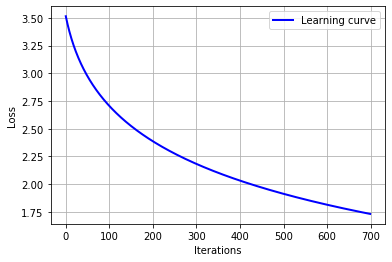

In [80]:
import matplotlib.pyplot as plt 
plt.figure()
plt.title("Newton method")
plt.plot(list(range(len(losses))), losses, color='blue', linewidth=2, label='Learning curve')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [108]:
model = binary_classification(n_features, 1, False, approx = True)
criterion = nn.BCELoss()
losses_approx = []
num_iter = 700

for i in range(num_iter):
    y_hat_train = model(X_train)     # Forward Pass
    loss = criterion(y_hat_train.squeeze(), y_train)
    loss.backward()      # backward Pass
    model.update(X_train, y_train)
    losses_approx.append(loss.item())
        
with torch.no_grad():
    model.eval()
    y_hat_test = model(X_test)
    loss = criterion(y_hat_test.squeeze(), y_test)

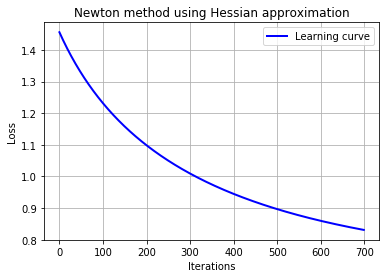

In [110]:
import matplotlib.pyplot as plt 
plt.figure()
plt.title("Newton method using Hessian approximation")
plt.plot(list(range(len(losses_approx))), losses_approx, color='blue', linewidth=2, label='Learning curve')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()